In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
path_prefix = './cs5228-2310-final-project/'
df_train = pd.read_csv(path_prefix + 'train.csv')
df_test = pd.read_csv(path_prefix + 'test.csv')

In [4]:
df_train.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100


In [34]:
#add nearest mrt distance and nearest primary school distance
def add_distance(df):
    df_mrt = pd.read_csv(path_prefix + 'auxiliary-data/auxiliary-data/sg-mrt-existing-stations.csv')
    df_primary = pd.read_csv(path_prefix + 'auxiliary-data/auxiliary-data/sg-primary-schools.csv')
    df_mrt['latitude'] = df_mrt['latitude'].astype('float64')
    df_mrt['longitude'] = df_mrt['longitude'].astype('float64')
    df_primary['latitude'] = df_primary['latitude'].astype('float64')
    df_primary['longitude'] = df_primary['longitude'].astype('float64')

    df['nearest_mrt'] = df.apply(lambda x: df_mrt.apply(lambda y: np.sqrt((x['latitude'] - y['latitude'])**2 + (x['longitude'] - y['longitude'])**2), axis=1).min(), axis=1)
    df['nearest_primary'] = df.apply(lambda x: df_primary.apply(lambda y: np.sqrt((x['latitude'] - y['latitude'])**2 + (x['longitude'] - y['longitude'])**2), axis=1).min(), axis=1)
    
    return df


In [35]:
df_train = add_distance(df_train)

## Data Preprocessing

In [36]:
#data clean
df_train.isnull().sum()

rent_approval_date     0
town                   0
block                  0
street_name            0
flat_type              0
flat_model             0
floor_area_sqm         0
furnished              0
lease_commence_date    0
latitude               0
longitude              0
elevation              0
subzone                0
planning_area          0
region                 0
monthly_rent           0
nearest_mrt            0
nearest_primary        0
dtype: int64

In [37]:
df_train.describe()

,floor_area_sqm,lease_commence_date,latitude,longitude,elevation,monthly_rent,nearest_mrt,nearest_primary
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.0,60000.000000,60000.000000,60000.000000
mean,94.480458,1990.876367,1.359443,103.840110,0.0,2590.328333,0.006378,0.003836
std,24.082642,12.141435,0.042505,0.071627,0.0,714.910468,0.003700,0.002243
min,34.000000,1966.000000,1.270380,103.685228,0.0,300.000000,0.000325,0.000385
25%,73.000000,1981.000000,1.330939,103.778803,0.0,2100.000000,0.003720,0.002231
50%,93.000000,1988.000000,1.354024,103.845301,0.0,2400.000000,0.005673,0.003446
75%,110.000000,2000.000000,1.386968,103.897418,0.0,3000.000000,0.008106,0.004855
max,215.000000,2019.000000,1.457071,103.964915,0.0,6950.000000,0.022259,0.018712


<Axes: >

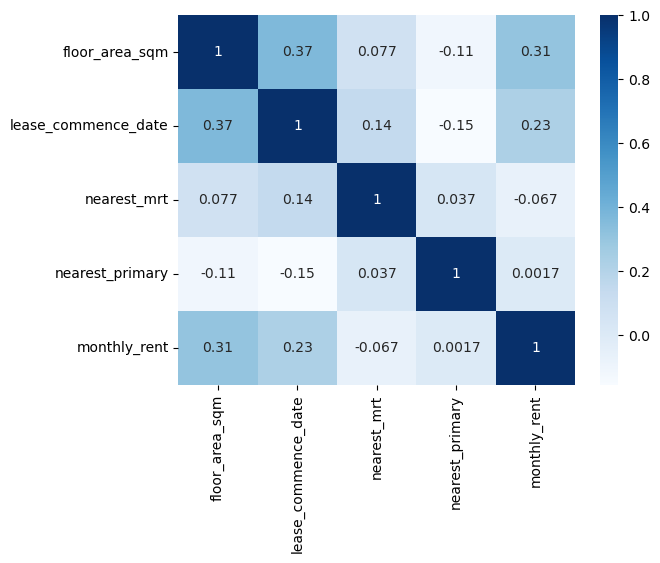

In [44]:
#draw corr heatmap
corr = df_train[['floor_area_sqm', 'lease_commence_date', 'nearest_mrt', 'nearest_primary', 'monthly_rent']].corr()
sns.heatmap(corr, annot=True, cmap='Blues')

c:\ProgramData\anaconda3\envs\CS5228\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


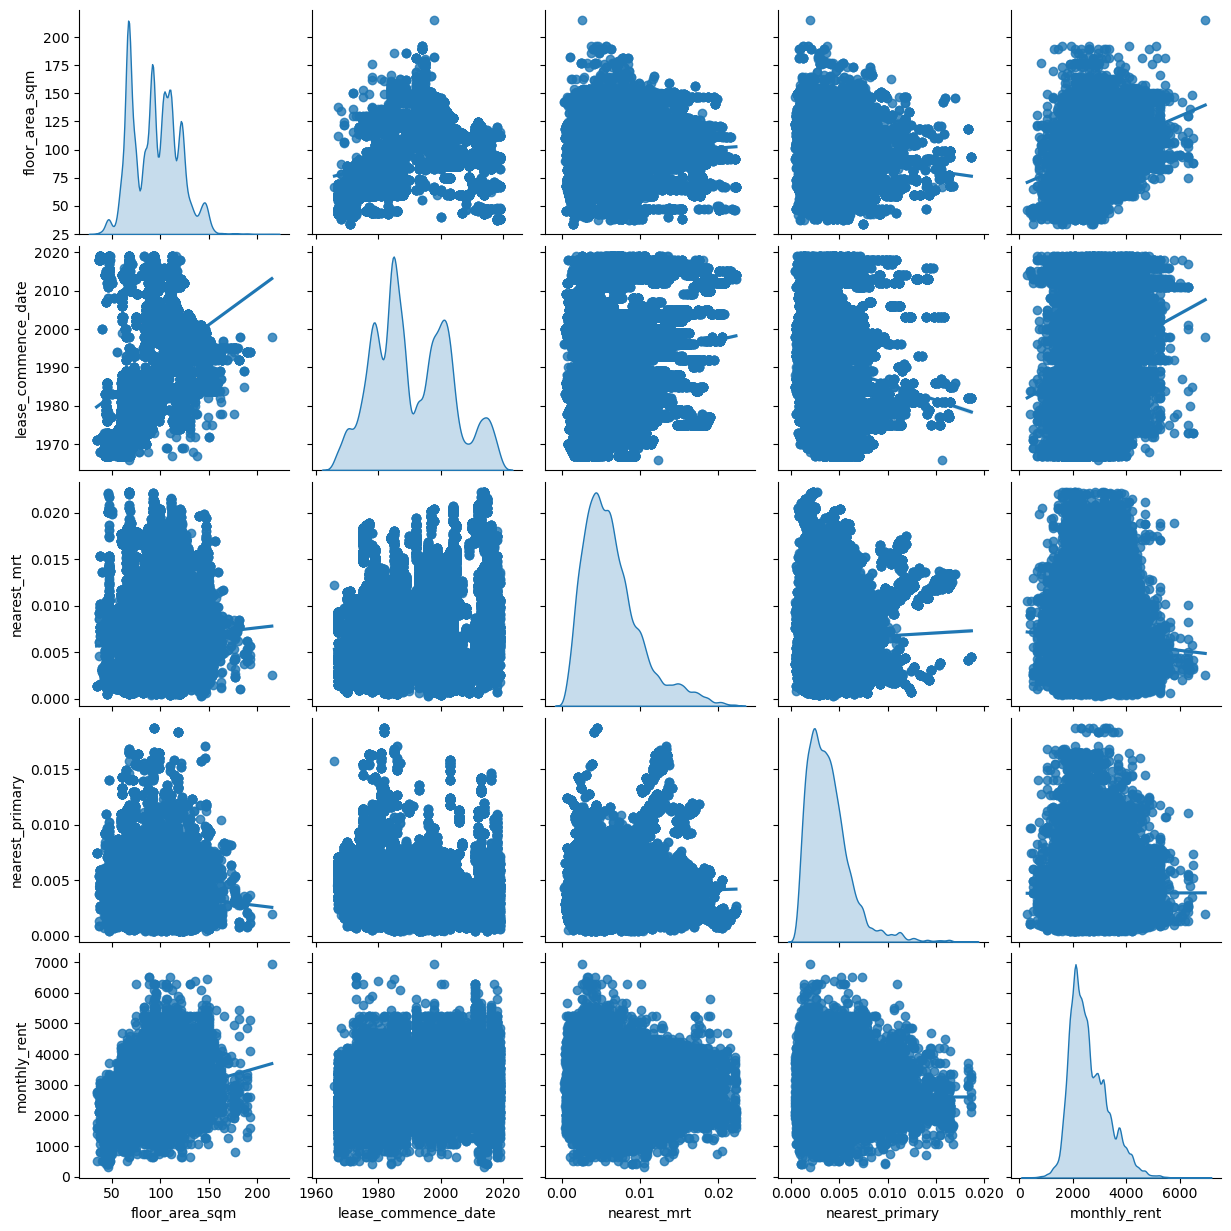

In [50]:
#draw corr distribution plot
sns.pairplot(df_train[['floor_area_sqm', 'lease_commence_date', 'nearest_mrt', 'nearest_primary', 'monthly_rent']], kind='reg', diag_kind='kde')


In [56]:
#cut distance into 2 bins
df_train['nearest_mrt in 500m'] = df_train['nearest_mrt'].apply(lambda x: 'yes' if x <= 0.5/111 else 'no')
df_train['nearest_primary in 1km'] = df_train['nearest_primary'].apply(lambda x: 'yes' if x <= 1.0/111 else 'no')

<Axes: xlabel='nearest_primary in 1km', ylabel='monthly_rent'>

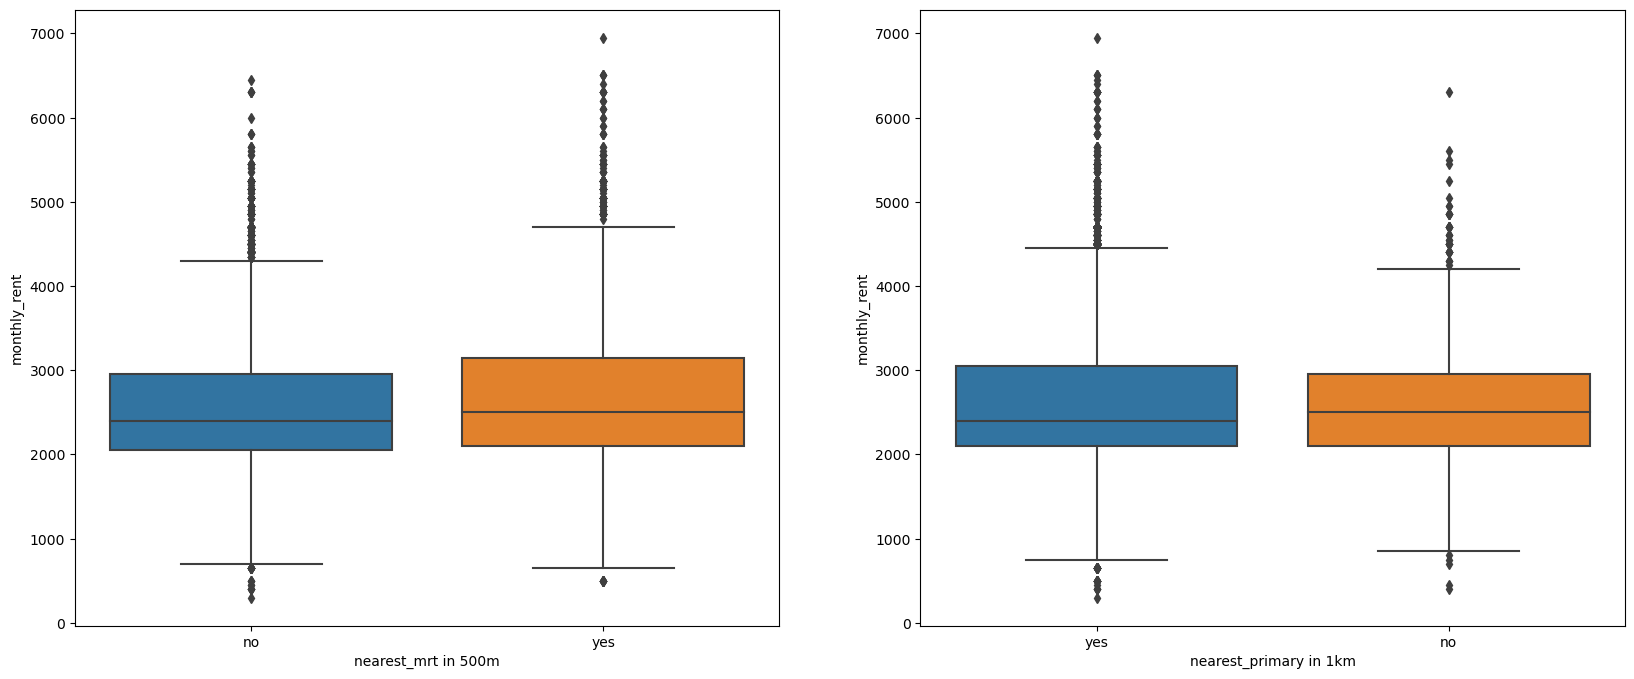

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.boxplot(x='nearest_mrt in 500m', y='monthly_rent', data=df_train, ax=ax[0])
sns.boxplot(x='nearest_primary in 1km', y='monthly_rent', data=df_train, ax=ax[1])

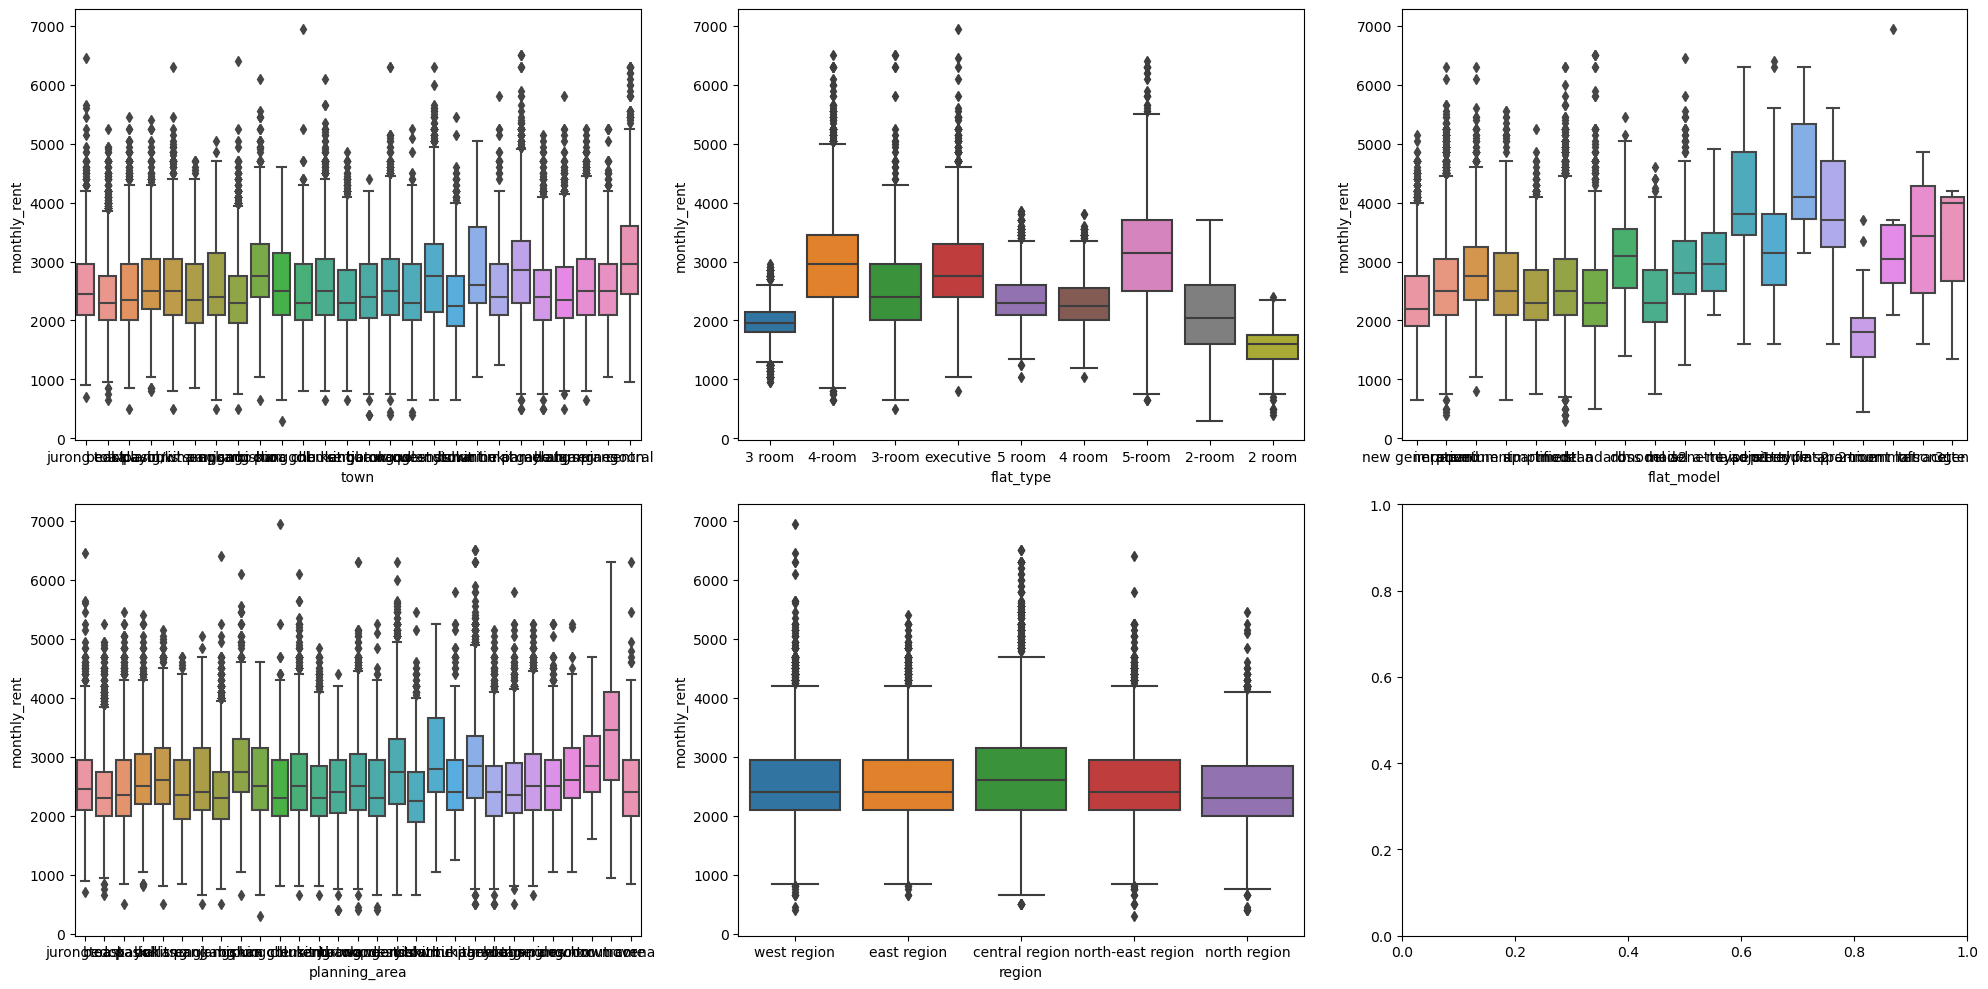

In [49]:
#draw distribution for categorical variables and monthly rent
#town	street_name	flat_type	flat_model	subzone	planning_area	region
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
sns.boxplot(x='town', y='monthly_rent', data=df_train, ax=ax[0, 0])
sns.boxplot(x='flat_type', y='monthly_rent', data=df_train, ax=ax[0, 1])
sns.boxplot(x='flat_model', y='monthly_rent', data=df_train, ax=ax[0, 2])
sns.boxplot(x='planning_area', y='monthly_rent', data=df_train, ax=ax[1, 0])
sns.boxplot(x='region', y='monthly_rent', data=df_train, ax=ax[1, 1])
plt.tight_layout()



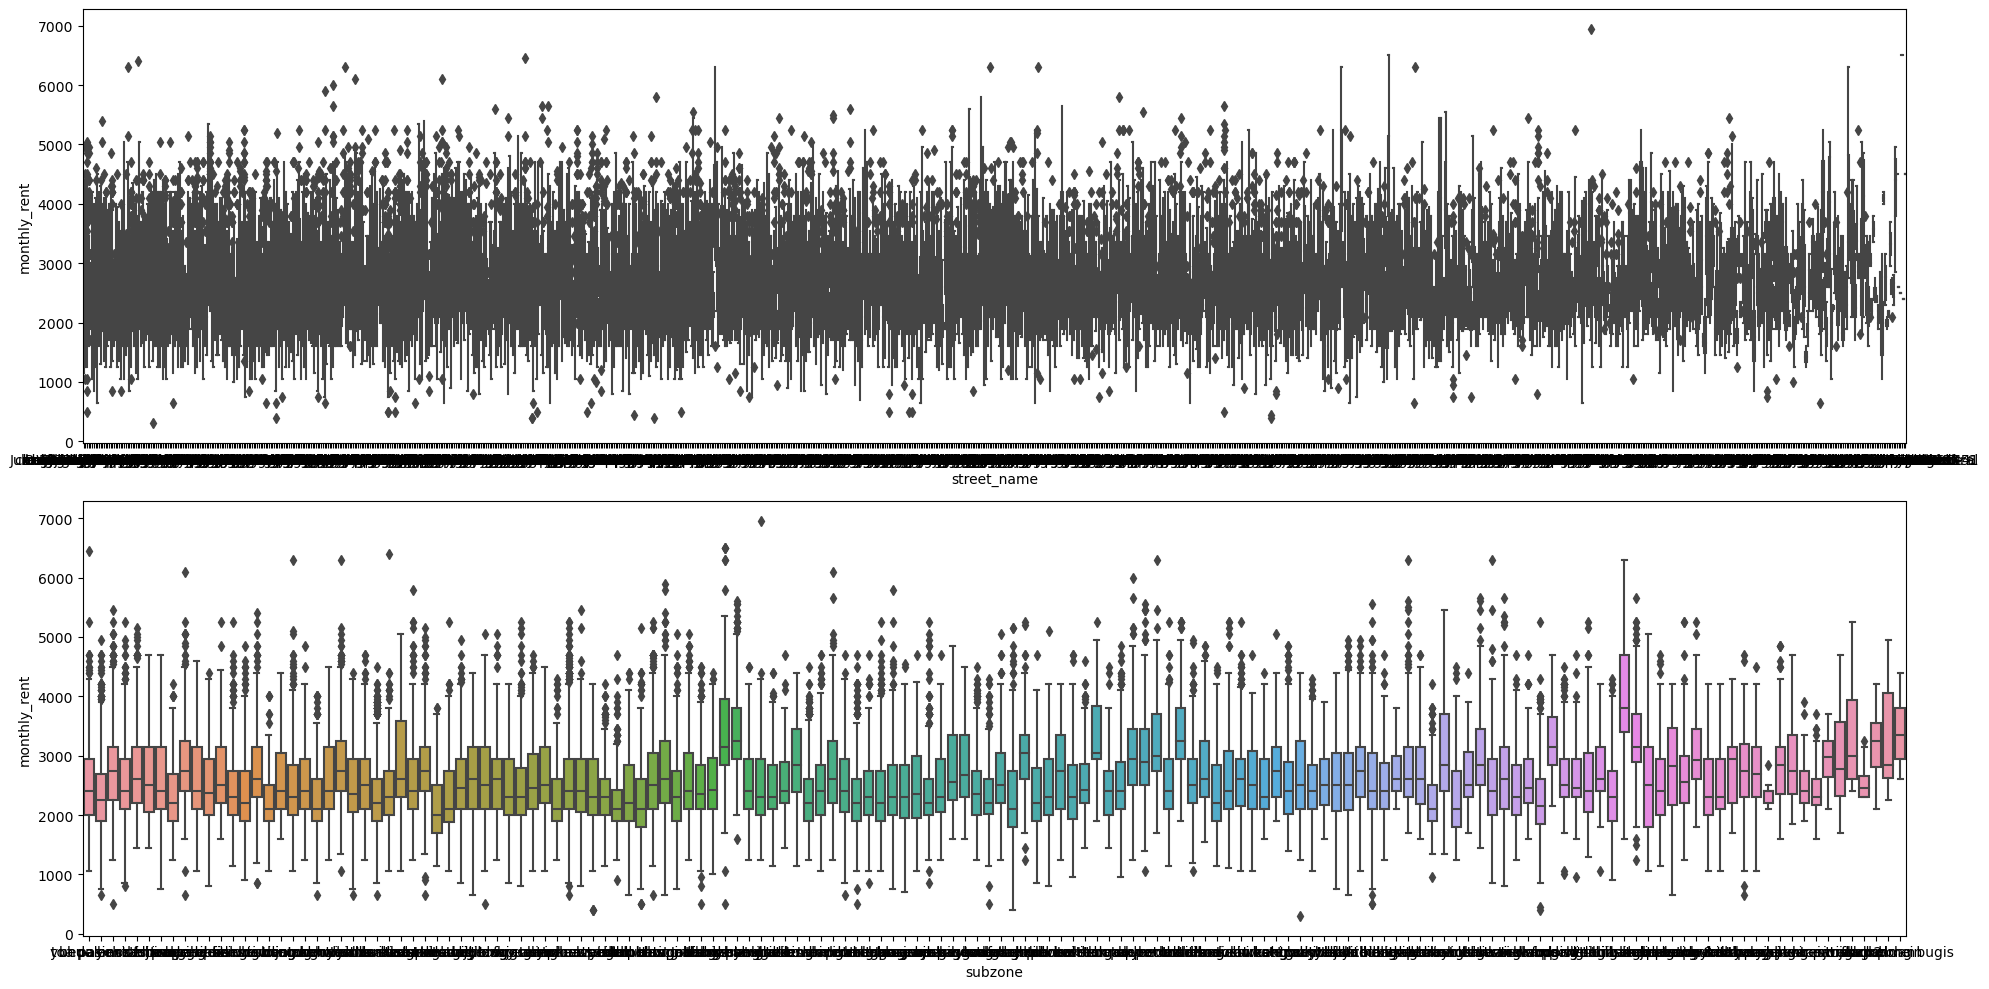

In [48]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.boxplot(x='street_name', y='monthly_rent', data=df_train, ax=ax[0,])
sns.boxplot(x='subzone', y='monthly_rent', data=df_train, ax=ax[1,])
plt.tight_layout()

In [155]:
#map all categorical variables to numerical variables
def category_map_ordinal_all(df_origin):
    df = df_origin.copy()
    #map town decrease order
    grouby_town = df_train.groupby('town')['monthly_rent'].mean().sort_values()
    town_map = grouby_town.index
    town_map_dict = {town_map[i]: i for i in range(len(town_map))}
    df['town'] = df['town'].apply(lambda x: town_map_dict[x] if x in town_map_dict else -1)

    #map flat_type decrease order
    grouby_flat_type = df_train.groupby('flat_type')['monthly_rent'].mean().sort_values()
    flat_type_map = grouby_flat_type.index
    flat_type_map_dict = {flat_type_map[i]: i for i in range(len(flat_type_map))}
    flat_type_map_dict
    df['flat_type'] = df['flat_type'].apply(lambda x: flat_type_map_dict[x] if x in flat_type_map_dict else -1)

    #map flat_model decrease order
    grouby_flat_model = df_train.groupby('flat_model')['monthly_rent'].mean().sort_values()
    flat_model_map = grouby_flat_model.index
    flat_model_map_dict = {flat_model_map[i]: i for i in range(len(flat_model_map))}
    df['flat_model'] = df['flat_model'].apply(lambda x: flat_model_map_dict[x] if x in flat_model_map_dict else -1)

    #map planning_area decrease order
    grouby_planning_area = df_train.groupby('planning_area')['monthly_rent'].mean().sort_values()
    planning_area_map = grouby_planning_area.index
    planning_area_map_dict = {planning_area_map[i]: i for i in range(len(planning_area_map))}
    df['planning_area'] = df['planning_area'].apply(lambda x: planning_area_map_dict[x] if x in planning_area_map_dict else -1)

    #map region decrease order
    grouby_region = df_train.groupby('region')['monthly_rent'].mean().sort_values()
    region_map = grouby_region.index
    region_map_dict = {region_map[i]: i for i in range(len(region_map))}
    df['region'] = df['region'].apply(lambda x: region_map_dict[x] if x in region_map_dict else -1)

    #map street_name decrease order
    grouby_street_name = df_train.groupby('street_name')['monthly_rent'].mean().sort_values()
    street_name_map = grouby_street_name.index
    street_name_map_dict = {street_name_map[i]: i for i in range(len(street_name_map))}
    df['street_name'] = df['street_name'].apply(lambda x: street_name_map_dict[x] if x in street_name_map_dict else -1)

    #map subzone decrease order
    grouby_subzone = df_train.groupby('subzone')['monthly_rent'].mean().sort_values()
    subzone_map = grouby_subzone.index
    subzone_map_dict = {subzone_map[i]: i for i in range(len(subzone_map))}
    df['subzone'] = df['subzone'].apply(lambda x: subzone_map_dict[x] if x in subzone_map_dict else -1)

    

    return df

Index(['town', 'street_name', 'flat_type', 'flat_model', 'floor_area_sqm',
       'lease_commence_date', 'latitude', 'longitude', 'subzone',
       'planning_area', 'region', 'monthly_rent', 'nearest_mrt',
       'nearest_primary'],
      dtype='object')

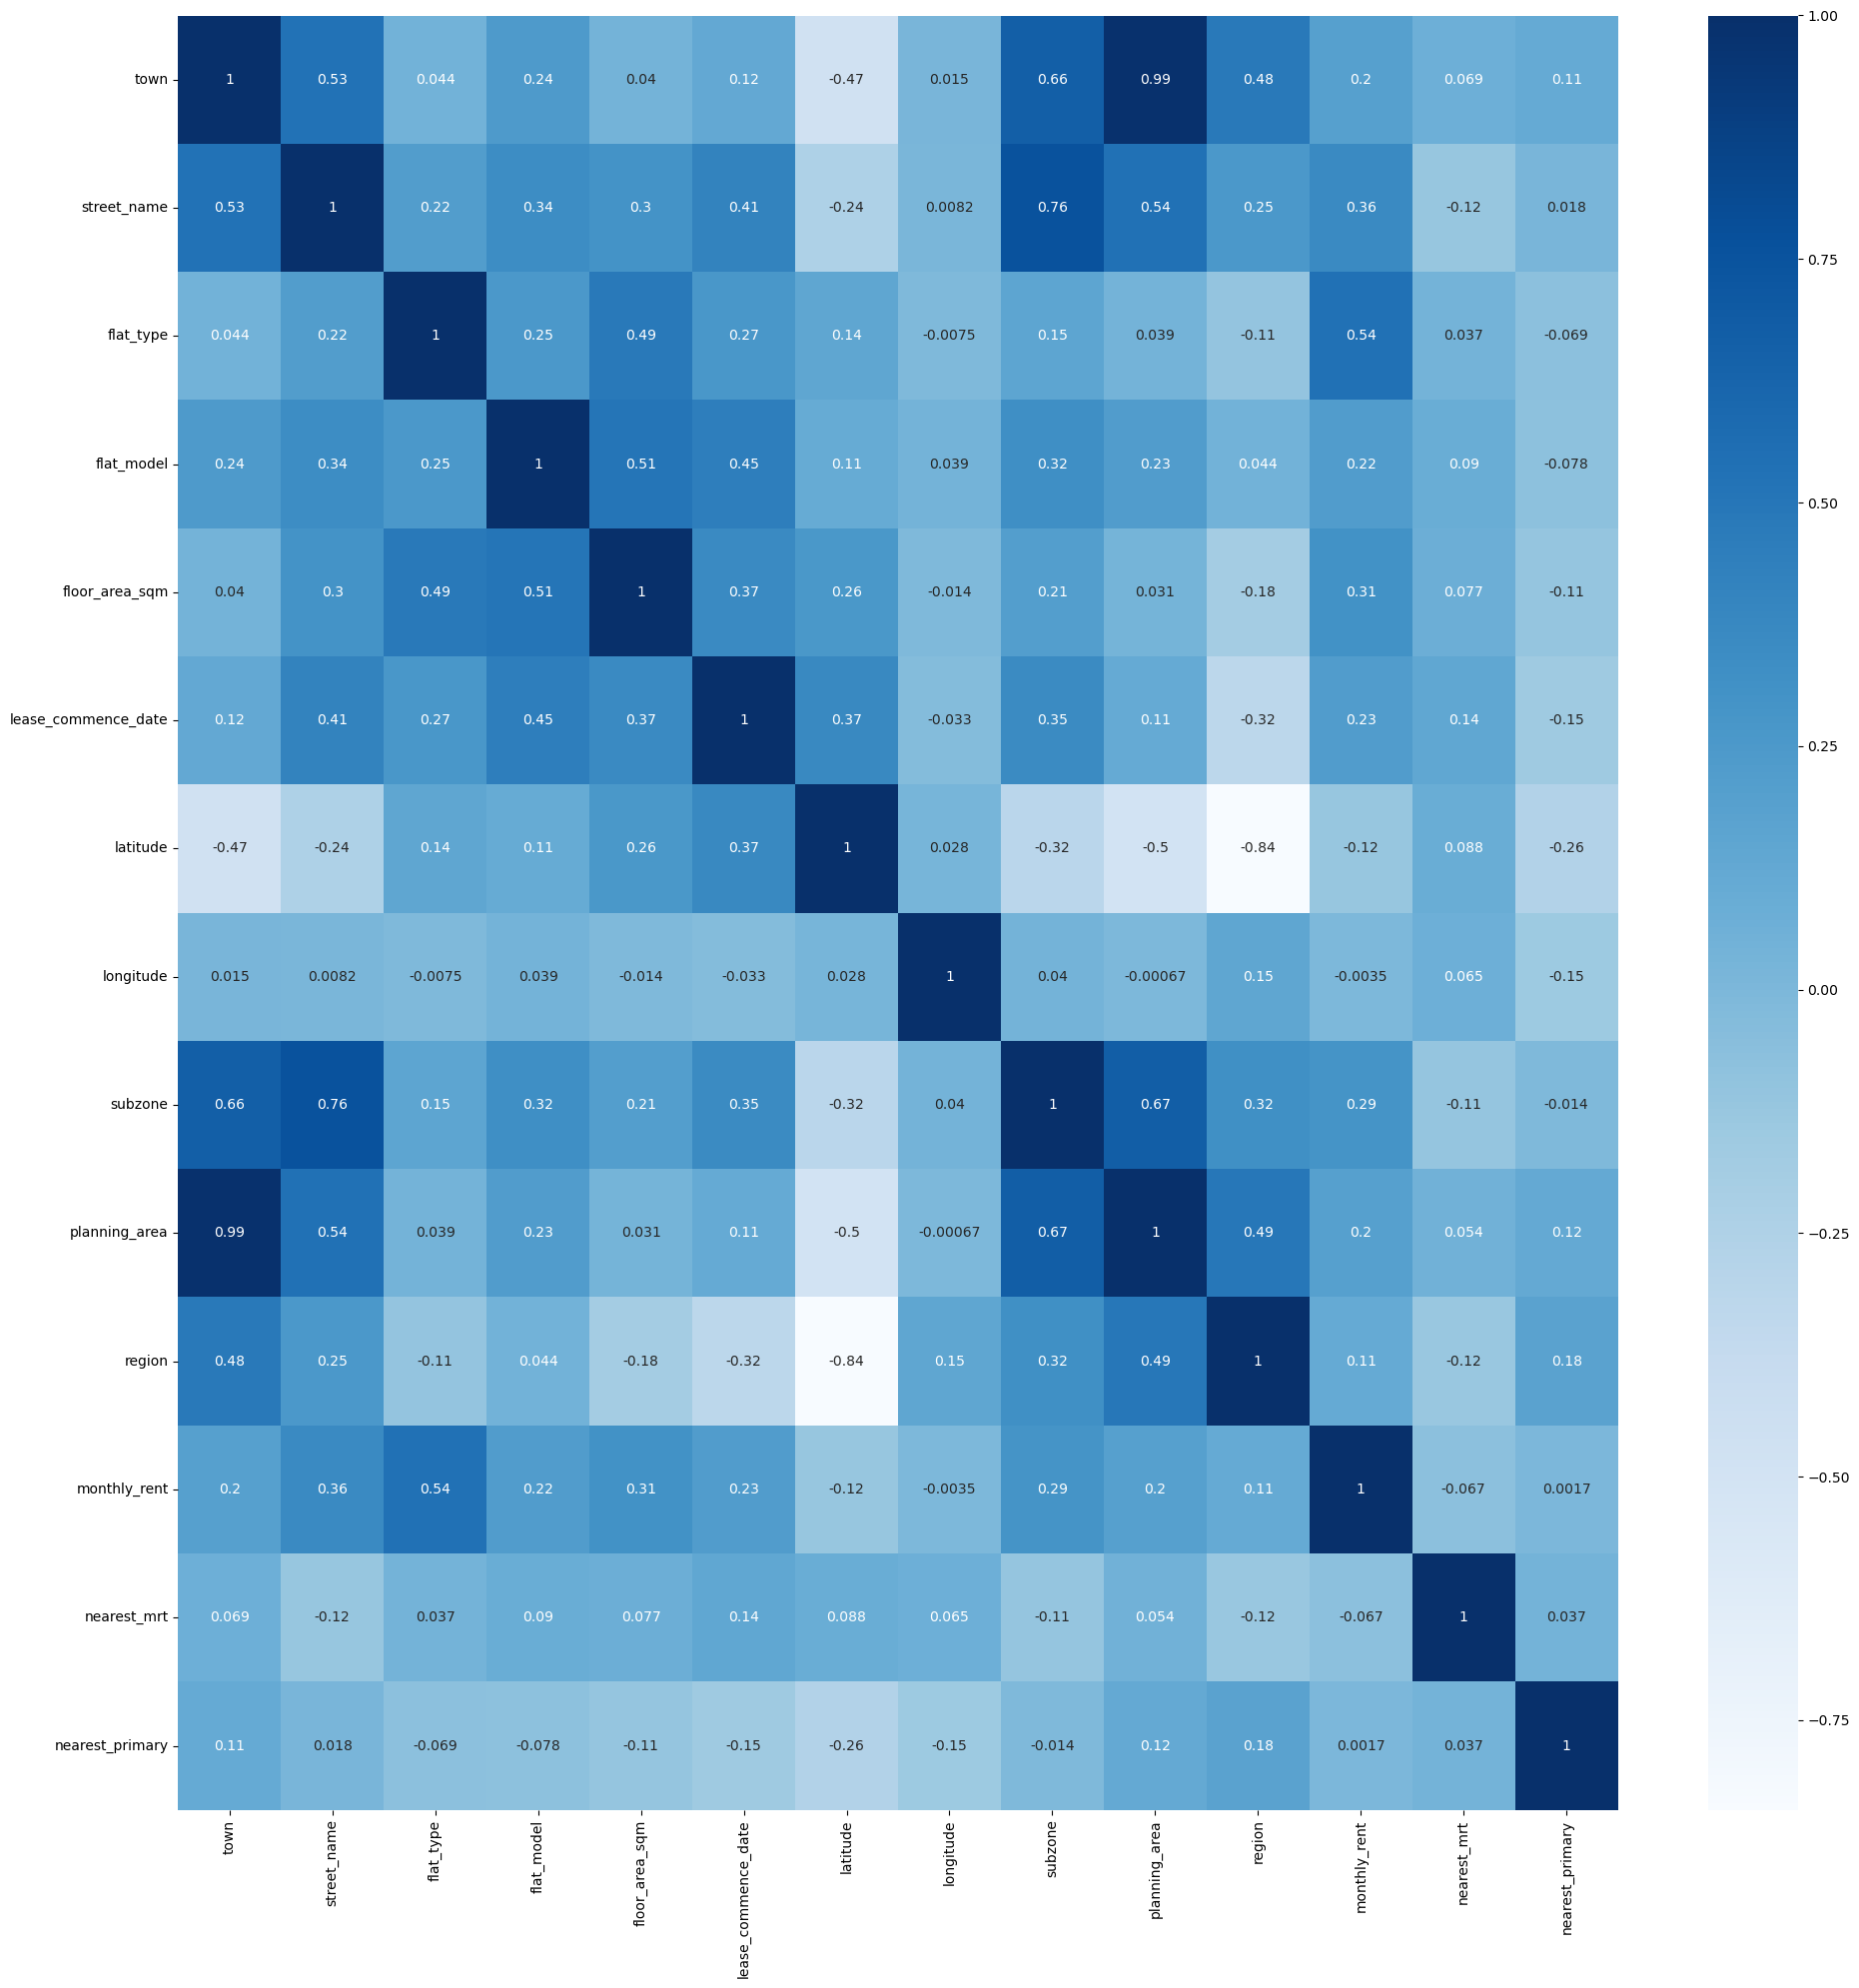

In [142]:
df_train_map_category = category_map_ordinal(df_train)
#only save int and float
df_train_map_category.dtypes
df_train_map_category = df_train_map_category.select_dtypes(include=['int64', 'float64'])
df_train_map_category.drop(['elevation'], axis=1, inplace=True)

plt.figure(figsize=(20, 20))
corr = df_train_map_category.corr()
sns.heatmap(corr, annot=True, cmap='Blues')
plt.tight_layout()
df_train_map_category.columns


## try with attributes
* town
* flat_type
* flat_model
* planning_area
* region
* floor_area_sqm
* lease_commence_date
* mrt in 500m
* primary school in 1km
## with method
* xgboost
* lgbm

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [60]:
def data_preprocess(df):
    df = add_distance(df)
    df['nearest_mrt in 500m'] = df['nearest_mrt'].apply(lambda x: 'yes' if x <= 0.5/111 else 'no')
    df['nearest_primary in 1km'] = df['nearest_primary'].apply(lambda x: 'yes' if x <= 1.0/111 else 'no')
    df =df[['floor_area_sqm', 'lease_commence_date', 'town', 'flat_type', 'flat_model', 'planning_area', 'region', 'nearest_mrt in 500m', 'nearest_primary in 1km']]
    return df

In [80]:
df_train_X = data_preprocess(df_train)
df_train_y = df_train['monthly_rent']
df_test_X = data_preprocess(df_test)

In [84]:
#map categorical variables to ordinal variables order by mean monthly rent
def category_map_ordinal(df_origin):
    df = df_origin.copy()
    #map town decrease order
    grouby_town = df_train.groupby('town')['monthly_rent'].mean().sort_values()
    town_map = grouby_town.index
    town_map_dict = {town_map[i]: i for i in range(len(town_map))}
    df['town'] = df['town'].apply(lambda x: town_map_dict[x])

    #map flat_type decrease order
    grouby_flat_type = df_train.groupby('flat_type')['monthly_rent'].mean().sort_values()
    flat_type_map = grouby_flat_type.index
    flat_type_map_dict = {flat_type_map[i]: i for i in range(len(flat_type_map))}
    flat_type_map_dict
    df['flat_type'] = df['flat_type'].apply(lambda x: flat_type_map_dict[x])

    #map flat_model decrease order
    grouby_flat_model = df_train.groupby('flat_model')['monthly_rent'].mean().sort_values()
    flat_model_map = grouby_flat_model.index
    flat_model_map_dict = {flat_model_map[i]: i for i in range(len(flat_model_map))}
    df['flat_model'] = df['flat_model'].apply(lambda x: flat_model_map_dict[x])

    #map planning_area decrease order
    grouby_planning_area = df_train.groupby('planning_area')['monthly_rent'].mean().sort_values()
    planning_area_map = grouby_planning_area.index
    planning_area_map_dict = {planning_area_map[i]: i for i in range(len(planning_area_map))}
    df['planning_area'] = df['planning_area'].apply(lambda x: planning_area_map_dict[x])

    #map region decrease order
    grouby_region = df_train.groupby('region')['monthly_rent'].mean().sort_values()
    region_map = grouby_region.index
    region_map_dict = {region_map[i]: i for i in range(len(region_map))}
    df['region'] = df['region'].apply(lambda x: region_map_dict[x])

    #map nearest_mrt in 500m
    df['nearest_mrt in 500m'] = df['nearest_mrt in 500m'].map({'yes': 1, 'no': 0})

    #map nearest_primary in 1km
    df['nearest_primary in 1km'] = df['nearest_primary in 1km'].map({'yes': 1, 'no': 0})

    return df


In [86]:
df_train_X = category_map_ordinal(df_train_X)
df_test_X = category_map_ordinal(df_test_X)

In [100]:
#cut 30% data as validation set
X_train, X_val, y_train, y_val = train_test_split(df_train_X, df_train_y, test_size=0.3, random_state=19260817)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 42000, number of used features: 9
[LightGBM] [Info] Start training from score 2586.378571
LGBM MAE:  422.8608242656959
LGBM RMSE:  550.4730944844948


<Axes: >

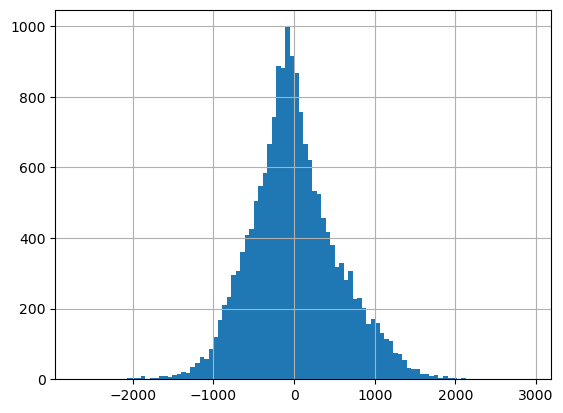

In [107]:
LGBM = LGBMRegressor(
    learning_rate=0.05,
    n_estimators=1000,
)

LGBM.fit(X_train, y_train)
y_pred = LGBM.predict(X_val)
print('LGBM MAE: ', mean_absolute_error(y_val, y_pred))
print('LGBM RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))
df_plot_diff = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
df_plot_diff['diff'] = df_plot_diff['y_val'] - df_plot_diff['y_pred']
df_plot_diff['diff'].hist(bins=100)



XGB MAE:  424.7328273078071
XGB RMSE:  554.2211950789912


<Axes: >

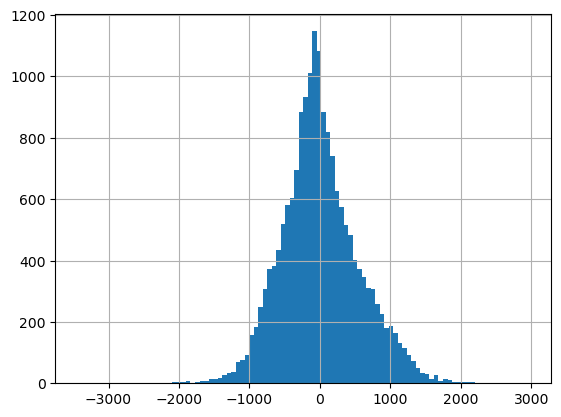

In [108]:
xgb = XGBRegressor(
    learning_rate=0.05,
    n_estimators=1000,
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
print('XGB MAE: ', mean_absolute_error(y_val, y_pred))
print('XGB RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))
df_plot_diff = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
df_plot_diff['diff'] = df_plot_diff['y_val'] - df_plot_diff['y_pred']
df_plot_diff['diff'].hist(bins=100)

merged MAE:  423.17497781860095
merged RMSE:  551.3616161439336


<Axes: >

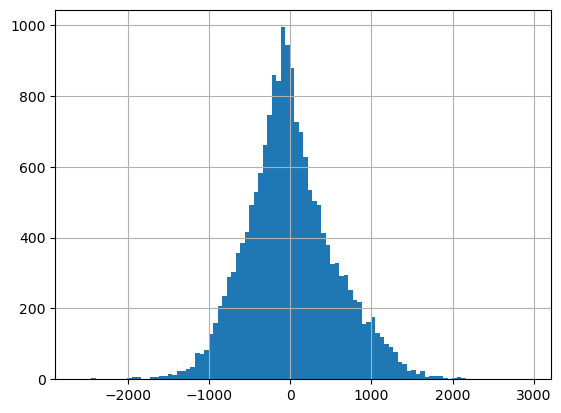

In [118]:
#merge xgb and lgbm
p = 0.5
y_pred = p * LGBM.predict(X_val) + (1 - p) * xgb.predict(X_val)
print('merged MAE: ', mean_absolute_error(y_val, y_pred))
print('merged RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))
df_plot_diff = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
df_plot_diff['diff'] = df_plot_diff['y_val'] - df_plot_diff['y_pred']
df_plot_diff['diff'].hist(bins=100)


## try sklearn pipeline

In [119]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [122]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

Text(0, 0.5, 'rmse')

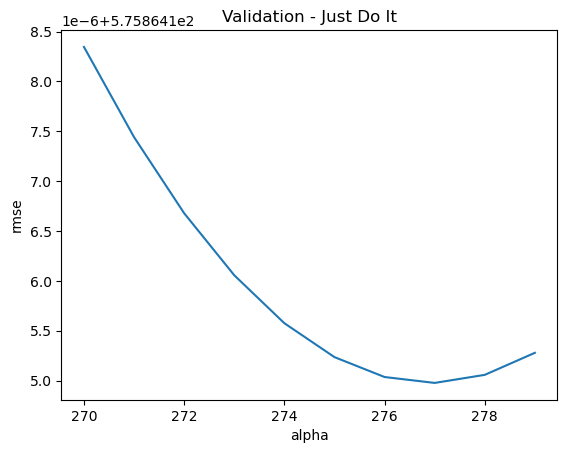

In [128]:
model_ridge = Ridge()
alphas = list(range(270, 280, 1))
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

ridge MAE:  444.7312903335289
ridge RMSE:  572.8865944028179


<Axes: >

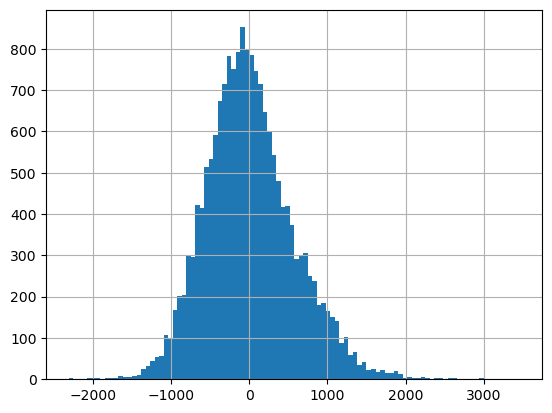

In [129]:
#predict with alpha=277
ridge = Ridge(alpha=277)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_val)
print('ridge MAE: ', mean_absolute_error(y_val, y_pred))
print('ridge RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))
df_plot_diff = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
df_plot_diff['diff'] = df_plot_diff['y_val'] - df_plot_diff['y_pred']
df_plot_diff['diff'].hist(bins=100)

## try with attributes corr > 0.29
* street_name
* flat_type
* floor_area_sqm
* subzone

In [140]:
df_train_map_category

,town,street_name,flat_type,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,subzone,planning_area,region,monthly_rent,nearest_mrt,nearest_primary
0,12,106,1,1,67.0,1983,1.344518,103.738630,60,13,2,1600,0.006289,0.003012
1,2,217,7,1,92.0,1978,1.330186,103.938717,16,2,3,2250,0.008087,0.005466
2,9,237,5,6,67.0,1971,1.332242,103.845643,116,9,4,1900,0.001966,0.003830
3,20,679,6,8,149.0,1993,1.370239,103.962894,86,20,3,2850,0.013908,0.005081
4,18,84,5,6,68.0,1972,1.320502,103.863341,115,21,4,2100,0.001690,0.002444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,1,184,1,1,67.0,1979,1.366050,103.854168,21,1,1,2200,0.006027,0.003244
59996,23,1050,7,5,83.0,2019,1.286493,103.821434,102,26,4,4100,0.005573,0.005061
59997,14,468,8,6,122.0,1988,1.355064,103.936507,79,15,3,2250,0.006503,0.002878
59998,2,502,8,3,123.0,1977,1.318974,103.944076,31,2,3,4700,0.008306,0.001975


In [146]:
df_train_X = df_train_map_category
df_train_y = df_train['monthly_rent']

#only save street_name, subzone, floor_area_sqm, flat_type
df_train_X = df_train_X[['street_name', 'subzone', 'floor_area_sqm', 'flat_type']]

,street_name,subzone,floor_area_sqm,flat_type
0,hougang street 22,lorong ah soo,121.0,5-room
1,sembawang vista,sembawang central,100.0,4-room
2,Clementi West Street 2,clementi west,91.0,4-room
3,Jurong East Street 31,yuhua west,74.0,3 room
4,jurong east street 32,yuhua west,121.0,5-room
...,...,...,...,...
29995,edgefield plains,waterway east,92.0,4-room
29996,admiralty link,sembawang north,90.0,4-room
29997,ang mo kio avenue 5,cheng san,68.0,3-room
29998,woodlands ring road,woodlands east,144.0,executive


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 42000, number of used features: 4
[LightGBM] [Info] Start training from score 2586.378571
LGBM MAE:  424.92072472608606
LGBM RMSE:  552.0329083545764


<Axes: >

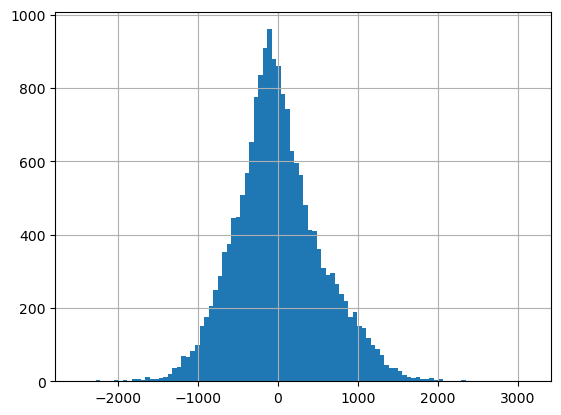

In [150]:
#cut 30% data as validation set
X_train, X_val, y_train, y_val = train_test_split(df_train_X, df_train_y, test_size=0.3, random_state=19260817)

LGBM = LGBMRegressor(
    learning_rate=0.01,
    n_estimators=5000,
)

LGBM.fit(X_train, y_train)
y_pred = LGBM.predict(X_val)
print('LGBM MAE: ', mean_absolute_error(y_val, y_pred))
print('LGBM RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))
df_plot_diff = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
df_plot_diff['diff'] = df_plot_diff['y_val'] - df_plot_diff['y_pred']
df_plot_diff['diff'].hist(bins=100)

In [161]:
df_test = pd.read_csv(path_prefix + 'test.csv')
df_test = category_map_ordinal_all(df_test)
df_test_X = df_test[['street_name', 'subzone', 'floor_area_sqm', 'flat_type']]
df_test_X


,street_name,subzone,floor_area_sqm,flat_type
0,197,29,121.0,8
1,587,74,100.0,7
2,495,22,91.0,7
3,836,24,74.0,1
4,104,24,121.0,8
...,...,...,...,...
29995,496,95,92.0,7
29996,221,41,90.0,7
29997,86,19,68.0,5
29998,431,45,144.0,6


In [163]:
df_submit = pd.read_csv(path_prefix + 'example-submission.csv')
df_submit['Predicted'] = LGBM.predict(df_test_X)
df_submit.to_csv('submission.csv', index=False)
#get 558.38867 score